In [4]:
import os
import io
import cv2
import shutil
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from IPython.display import FileLink
from keras.applications import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [5]:
files = os.listdir("/kaggle/input/mirflickr25k/mirflickr25k/mirflickr")
files = [x for x in files if x.endswith(".jpg")]
files = files[:2500]

In [ ]:
os.mkdir("LR")
os.mkdir("HR")

In [ ]:
shutil.rmtree("LR")

In [ ]:
file_paths = [os.path.join("/kaggle/input/mirflickr25k/mirflickr25k/mirflickr", x) for x in files[:2500]]
#read and resize the images
def read_images(file_path, size, mode = "lr"):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size,size))
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)
    #if mode == "lr":
        #img = img /255.0
    #elif mode == "hr":
    
    #img = img / 255.0
    return img

for i,file_path in tqdm(enumerate(file_paths)):
    img_hr = read_images(file_path,128, mode = 'hr')
    img_lr = read_images(file_path,32, mode = 'lr')
    np.save("/kaggle/working/HR/img{}.npy".format(i), img_hr)
    np.save("/kaggle/working/LR/img{}.npy".format(i), img_lr)

In [6]:
#read the data
lr = os.listdir("/kaggle/working/LR")
hr = os.listdir("/kaggle/working/HR")

lr.sort()
hr.sort()

gen_paths = [os.path.join("/kaggle/working/LR", x) for x in lr]
disc_paths = [os.path.join("/kaggle/working/HR", x) for x in hr]

In [7]:
#read images
def read_images(file_paths):
    imgs = []
    for file_path in tqdm(file_paths):
        img = np.load(file_path)
        imgs.append(img)
    return np.array(imgs)

lr_images = read_images(gen_paths)
hr_images = read_images(disc_paths)
#lr_images=lr_images[:2500]
#hr_images = hr_images[:2500]
def denormalize_img(img):
    return ((img * 127.5) + 127.5).astype(np.uint8)

def mini_batches_(X, Y, batch_size=64):
    """
    function to produce minibatches for training
    :param X: input placeholder
    :param Y: mask placeholder
    :param batch_size: size of each batch
    :return:
    minibatches for training
    
    """
    gen_images = []
    disc_images = []
    train_length = len(X)
    num_batches = int(np.floor(train_length / batch_size))
    for i in tqdm(range(num_batches)):
        batch_x = X[i * batch_size: i * batch_size + batch_size]
        batch_y = Y[i * batch_size: i * batch_size + batch_size]
        batch_x = load_img(batch_x)
        batch_y = load_img(batch_y)
        gen_images.append(batch_x)
        disc_images.append(batch_y)
    return gen_images, disc_images

#gen_images, disc_images = mini_batches_(gen_paths, disc_paths, batch_size=64)

100%|██████████| 2500/2500 [00:01<00:00, 2303.14it/s]


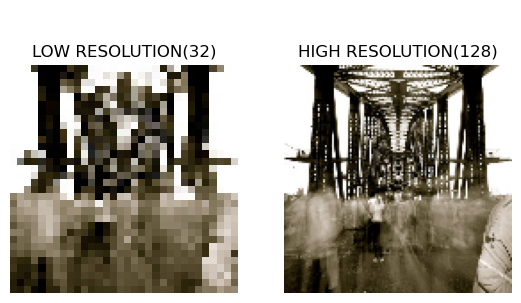

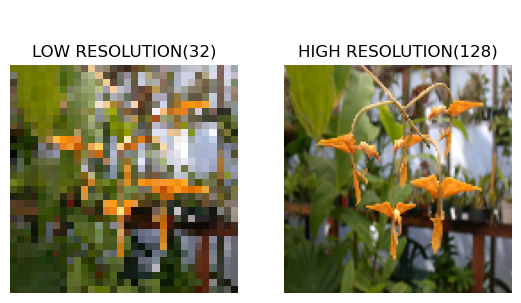

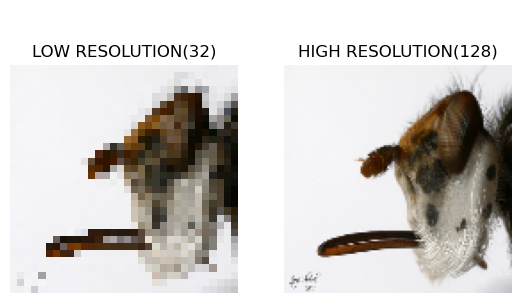

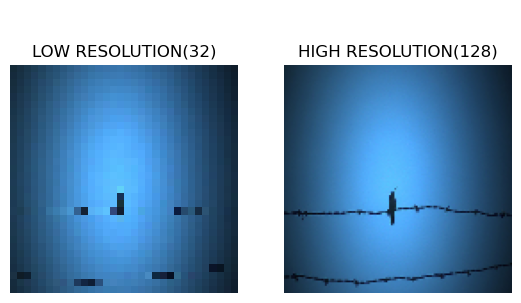

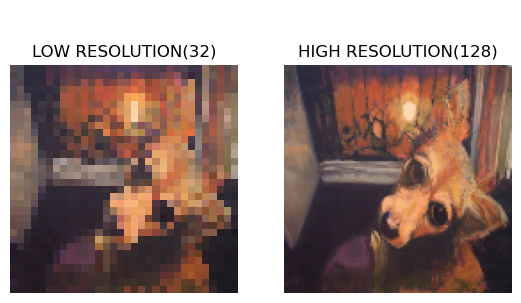

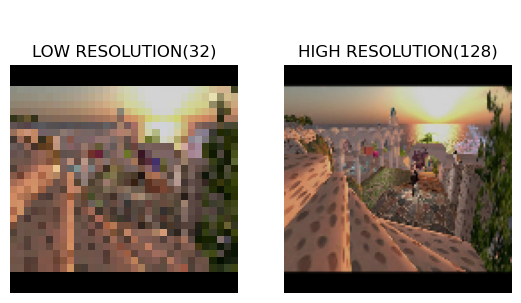

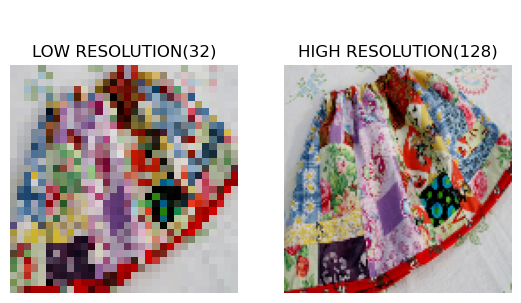

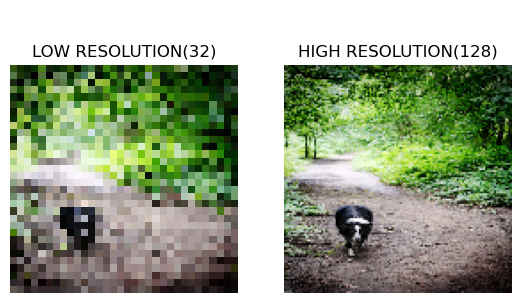

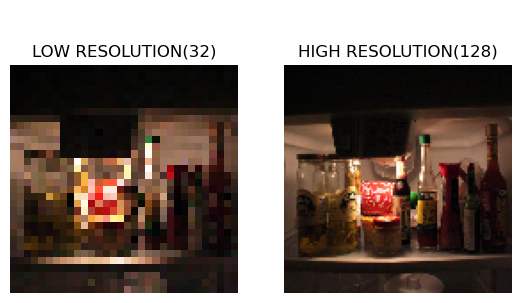

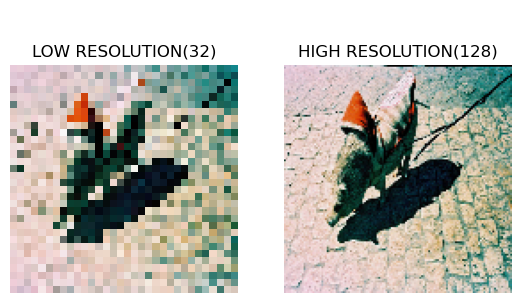

In [8]:
for i in range(10,20):
    plt.figure(figsize=(10, 10))
    plt.subplot(231)
    plt.title("\n\nLOW RESOLUTION(32)")
    plt.imshow(denormalize_img(lr_images[i]))
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(denormalize_img(hr_images[i]))
    plt.title("\n\nHIGH RESOLUTION(128)")
    plt.axis('off')

## Network

In [9]:
def conv2d(x, filter_size, filters, stride = 1, padding = 'same'):
    x = tf.keras.layers.Conv2D(filters,(filter_size,filter_size), strides =(stride,stride), padding = padding)(x)
    return x

def prelu(x):
    x = tf.keras.layers.PReLU()(x)
    return x

def batch_norm(x):
    x = tf.keras.layers.BatchNormalization()(x)
    return x


def resnet_block(prev_input):
    #res1
    x = conv2d(prev_input, 3, 64, padding = 'same')
    x = batch_norm(x)
    x = prelu(x)
    #res2
    x = conv2d(x, 3, 64, padding = 'same')
    x = batch_norm(x)

    output = tf.keras.layers.add([prev_input, x])
    return output

def upsample_block(prev_input):
    x = conv2d(prev_input, 3, 256, padding = 'same')
    x = tf.keras.layers.UpSampling2D(size = 2)(x)
    x = prelu(x)
    return x

def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha = 0.2)(x)

In [ ]:
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import LeakyReLU, PReLU
from keras.layers import add
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model


def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model



In [10]:
from keras.layers.core import Activation

class SRGAN(tf.keras.Model):
    def __init__(self, batch_size = 1):
        super(SRGAN, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = 0.0001

        self.gen_net = self.generator()
        self.disc_net = self.discriminator()
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        self.mean_square = tf.keras.losses.MeanSquaredError()
        
        self.vgg_output_hr = self.vgg_output(input_shape = (128,128,3), output_layer = 20)
        
    def generator(self,resnet_blocks = 16):
        low_lr_input = tf.keras.layers.Input(shape = (32,32,3))
        #conv1
        x = conv2d(low_lr_input, 9, 64, padding = 'same')
        x = prelu(x)
        
        #save the current output. This will be added with the residual blcok output.
        conv1_out = x
        
        #Residual blocks
        for _ in range(resnet_blocks):
            x = resnet_block(x)
        
        #conv2
        x = conv2d(x, 3, 64, padding = 'same')
        x = batch_norm(x)
        
        x = tf.keras.layers.add([x, conv1_out]) # add the conv1_out and x(from residual block)

        #upsample output
        x = upsample_block(x)
        x = upsample_block(x)
        
        x = conv2d(x,9,3,padding = 'same')
        out = Activation('tanh')(x)
        model = tf.keras.Model(inputs = low_lr_input, outputs = out)
        
        return model
    
    
    def discriminator(self):
        high_hr_input = tf.keras.Input(shape = (128,128,3))
        #conv1
        x = conv2d(high_hr_input, 3, 64)
        x = leaky_relu(x)
        #conv2 
        x = conv2d(x,3,64, stride = 2)
        x = batch_norm(x)
        x = leaky_relu(x)
        #conv3
        x = conv2d(x,3, 64*2)
        x = batch_norm(x)
        x = leaky_relu(x)
        #conv4
        x = conv2d(x, 3, 64*2, stride = 2)
        x = batch_norm(x)
        x = leaky_relu(x)
        #conv5
        x = conv2d(x,3,64*4)
        x = batch_norm(x)
        x = leaky_relu(x)
        #conv6
        x = conv2d(x,3,64*4, stride = 2)
        x = batch_norm(x)
        x = leaky_relu(x)
        x = conv2d(x,3,64*8)
        x = batch_norm(x)
        x = leaky_relu(x)
        x = conv2d(x,3,64*8, stride = 2)
        x = batch_norm(x)
        x = leaky_relu(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(64*16)(x)
        x = leaky_relu(x)
        out = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
        
        model = tf.keras.Model(high_hr_input, out)
        return model
    
    
    #losses
    def vgg_output(self, input_shape,output_layer):
        vgg = VGG19(weights = "imagenet", include_top = False, input_shape = input_shape)
        return tf.keras.Model(inputs = vgg.input, outputs = vgg.layers[output_layer].output)
    
    def discriminator_loss(self,real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def perpectual_loss(self, real_images, gan_output_fake ):
        #real_images = preprocess_input(real_images)
        #gan_output_fake = preprocess_input(gan_output_fake)
        sr_features = self.vgg_output_hr(gan_output_fake)
        hr_features = self.vgg_output_hr(real_images)
        
        loss = self.mean_square(hr_features, sr_features)
        return loss
    
    def generator_loss(self, disc_gen_output):
        loss = self.cross_entropy(tf.ones_like(disc_gen_output), disc_gen_output) 
        return loss
    
        
    def compile(self, gen_opt, disc_opt):
        super(SRGAN, self).compile()
        #self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate , beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
        #self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate , beta_1=0.0, beta_2=0.99, epsilon=1e-8)
        self.generator_optimizer = gen_opt
        self.discriminator_optimizer = disc_opt
        
        self.gen_loss = self.generator_loss
        self.disc_loss = self.discriminator_loss
        
    
    def train_step(self, gan_dataset):
        batch_x, batch_y = gan_dataset
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_hr = self.gen_net(batch_x, training = True)
            
            real_output = self.disc_net(batch_y, training = True)
            fake_output = self.disc_net(gen_hr, training = True)
            
            #content loss
            per_loss = self.perpectual_loss(batch_y, gen_hr)
            gen_loss = self.gen_loss(fake_output)
             
            psnr = tf.image.psnr(gen_hr, batch_y, max_val=1.0)
            ssim = tf.image.ssim(gen_hr, batch_y, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
            mse = self.mean_square(batch_y, gen_hr)
            
            total_gen_loss = per_loss + 0.001 * gen_loss
            #disc_loss
            disc_loss = self.disc_loss(real_output, fake_output)
        
        gen_grads = gen_tape.gradient(total_gen_loss, self.gen_net.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.gen_net.trainable_variables))
        
        disc_grads =  disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.disc_net.trainable_variables))
        
        return {
            "Gen_loss": total_gen_loss,
            "Disc_loss": disc_loss,
            "psnr": psnr,
            "ssim": ssim,
            "mse": mse
            }     

gan = SRGAN()
gan.compile(tf.keras.optimizers.Adam(learning_rate=0.0001 , beta_1=0.0, beta_2=0.99, epsilon=1e-8),
           tf.keras.optimizers.Adam(learning_rate=0.0001 , beta_1=0.0, beta_2=0.99, epsilon=1e-8))     

In [ ]:
os.mkdir("model_weights")

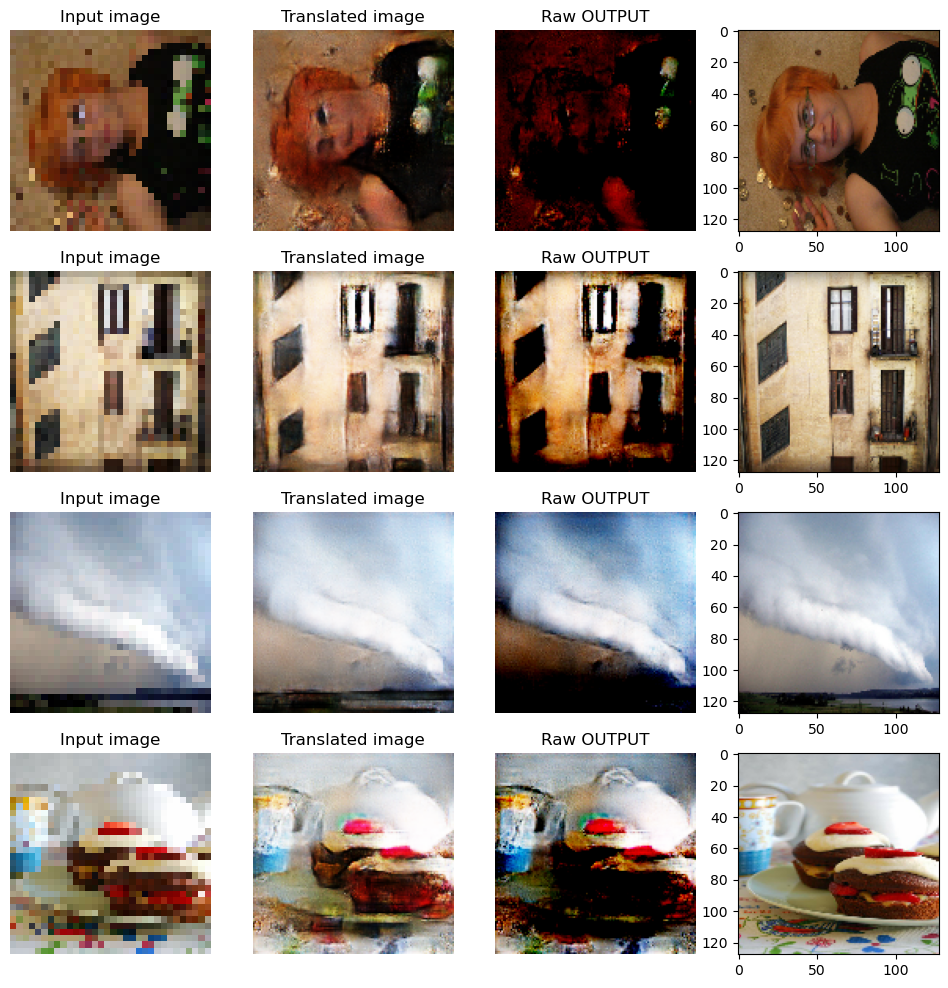

2500/2500 [==============================] - 131s 53ms/step - Gen_loss: 0.0246 - Disc_loss: 0.1457
Epoch 52/200
1707/2500 [===================>..........] - ETA: 40s - Gen_loss: 0.0249 - Disc_loss: 0.1421

In [ ]:
gan.fit(x = lr_images, y = hr_images ,epochs=200,
        batch_size = 1,
    callbacks=[plotter])

In [12]:
from IPython import display
class GANMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch %5==0 and epoch!=0:
            display.clear_output()
        _, ax = plt.subplots(4, 4, figsize=(12, 12))
        for i in range(4):
            r = np.random.randint(0,2000)
            img = lr_images[r]
            img = np.expand_dims(img, axis = 0)
            prediction = self.model.gen_net(img).numpy()
            #prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            #img = (img[0] * 127.5 + 127.5).astype(np.uint8)

            ax[i, 0].imshow(denormalize_img(img[0]))
            ax[i, 1].imshow(denormalize_img(prediction[0]))
            ax[i, 2].imshow(prediction[0])
            ax[i, 3].imshow(denormalize_img(hr_images[r]))
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 2].set_title("Raw OUTPUT")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")
            ax[i, 2].axis("off")

            """prediction = tf.keras.preprocessing.image.array_to_img(prediction[0])
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )"""
        if epoch % 25 == 0:
            self.model.gen_net.save_weights("/kaggle/working/gen_weights{}.h5".format(epoch))
            self.model.disc_net.save_weights("/kaggle/working/disc_weights{}.h5".format(epoch))
        plt.show()
        plt.close()
        
plotter = GANMonitor()